In [1]:
import scvelo as scv
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [332]:
import random
from sklearn.neighbors import NearestNeighbors

def simulate_space(adata:'AnnData',how:str='random',size_x:str=1000,size_y:str=1000,spread:int=10):
    '''Simulate the spatial distribution of cells
    Parameters
    ----------
    adata:'AnnData object'
        Adata object including previously simulated cells 
    how:'str'
        Method to use to simulate the space.Options are:
            - 'random': assign a random position to each cell
            - 'spatial_gradient': cells are positioned forming a gradient in y according to their diff. trajectory, included in (y).
    size_x:'float':
        X dimension of the tissue space simulated 
    size_y:'float':
        Y dimension of the tissue space simulated
    spread:'int':
        If 'spatial_gradient' is considered as a method, spreads indicates how many units can the Y coordinate of a cell differ the Y position predicted from 'true_t'
        The higher this value is, the less clear the gradient will be
    Returns
    -------
    adata:'AnnData object'
        Adata object including previously simulated cells with spatial positions
    
    '''
    if how=='random':
        n_cells=adata.obs.shape[0]
        xpos=[random.uniform(0,size_x) for _ in range(n_cells)]
        ypos=[random.uniform(0,size_y) for _ in range(n_cells)]
    if how=='spatial_gradient':
        n_cells=adata.obs.shape[0]
        xpos=[random.uniform(0,size_x) for _ in range(n_cells)]
        n_cells=adata.obs.shape[0]
        relative_y=a.obs['true_t'].div(a.obs['true_t'].max())*size_y
        ypos=[i+random.uniform(-spread,spread) for i in relative_y]

    adata.obs['x']=xpos
    adata.obs['y']=ypos
    adata.obsm['spatial']=np.array([list(xpos),list(ypos)]).transpose()
    return adata

def simulate_missegmentation(adata:'AnnData',max_distance_misseg:float=10,max_missegmentation_proportion:float=0.1):
    """Identify the presence of missegmented cells and simulate missegmentation
    Parameters
    ----------
    adata:'AnnData object'
        Adata object including previously simulated cells and spatial positions
    max_distance_misseg:'float'
        Maximum distance that is consider to assume two cells are missegmented. Cells presented at a shorter distance are
        considered to be missegmented
    max_missegmentation_proportion:'float'
        Maximum proportion of the cytoplasmic transcripts of cell1 that can be detected by the missegmented neighboring cell2.

    Returns
    -------
    adata:'AnnData object'
        Adata object containing all cells inputed, whose expression now included the computed missegmentation.
        A new column called 'missegmented cell' is included in obs to identify cells that are considered as missegmented.
    """
    
    
    # we define the closest neighbor to each cell
    knn = NearestNeighbors(n_neighbors=2)
    knn.fit(adata.obsm['spatial'])
    distance_mat, neighbours_mat = knn.kneighbors(adata.obsm['spatial'])
    cell_of_interest=neighbours_mat[:,0]
    closest_cell=neighbours_mat[:,1]
    closest_cell_distance=distance_mat[:,1]

    # we filter cells to keep only the missegmented ones
    misseg_cell2=closest_cell[closest_cell_distance<max_distance_misseg]
    misseg_cell1=cell_of_interest[closest_cell_distance<max_distance_misseg]
    misseg_distance=closest_cell_distance[closest_cell_distance<max_distance_misseg]
    
    # we next extract the expression matrix of cells from adata, together with the spliced and unspliced counts
    expression=np.array(adata.X)
    spliced_expression=adata.layers['spliced']
    unspliced_expression=adata.layers['unspliced']
    
    # for every cell we identified as missgmented, we transfer part of the expression between misseg cells
    for index in range(0,len(misseg_cell1)):
        cell1=misseg_cell1[index]
        cell2=misseg_cell2[index]
        added_expression=spliced_expression[cell2,:]*random.uniform(0,max_missegmentation_proportion)
        spliced_expression[cell1,:]=spliced_expression[cell1,:]+added_expression
        spliced_expression[cell2,:]=spliced_expression[cell2,:]-added_expression
        expression[cell1,:]=expression[cell1,:]+added_expression
        expression[cell2,:]=expression[cell2,:]-added_expression

    adata.X=expression
    adata.layers['spliced']=spliced_expression
    adata.layers['unspliced']=unspliced_expression
    # we add a variable in the adata specifying wether the cell is missegmented or not
    adata.obs['missegmented_cell']=list(adata.obs.index.astype(int).isin(misseg_cell1))
    
    return adata

def simulate_cytoplasmic_leakage(adata:'AnnData',max_cytoplasmic_leakage:float=0.1):
    ''' Simulate cytoplasmic counts considered nuclear due to 2D segmentation of a 3D nuclei.
    We consider this effect is systematic in all cells, but due to sampling some genes can be more affected than others
     ----------
    adata:'AnnData object'
        Adata object including previously simulated cells 
    max_cytoplasmic_leakage:float
        Maximum proportion of cytoplasmic counts that can leak into the nucleus counts do 2D segmentation
    Returns
    -------
    adata:'AnnData object'
        Adata object including previously cells where leakage has been simulated
    '''

    expression=np.array(adata.X)
    spliced_expression=adata.layers['spliced']
    unspliced_expression=adata.layers['unspliced']
    allperc=[]
    for index in range(expression.shape[0]):
        perc=[random.uniform(0,max_cytoplasmic_leakage) for e in range(expression.shape[1])]
        allperc.append(np.mean(perc))
        added_expression=spliced_expression[index,:]*perc
        spliced_expression[index,:]=spliced_expression[index,:]-added_expression
        unspliced_expression[index,:]=unspliced_expression[index,:]+added_expression

    adata.X=expression
    adata.layers['spliced']=spliced_expression
    adata.layers['unspliced']=unspliced_expression
    adata.obs['mean_leakage']=allperc
    return adata

def simulate_boundary_underestimation(adata:'AnnData',max_cyto_prop_lost:float=0.1,how:str='random'):
    ''' Simulate an underestimation of the boundaries
     ----------
    adata:'AnnData object'
        Adata object including previously simulated cells 
    max_cyto_prop_lost:float
        Maximum proportion of cytoplasmic counts not properly segmented due do cell boundary underestimation
    how:str
        Method to simulate boundary underestimation. It can be 'random','with_descending_trajectory' or 'with ascending trajectory'
    Returns
    -------
    adata:'AnnData object'
        Adata object including previously cells where cell boundary underestimation has been considered
    '''

    expression=np.array(adata.X)
    spliced_expression=adata.layers['spliced']
    unspliced_expression=adata.layers['unspliced']
    allperc=[]
    if how=='random':
        for index in range(expression.shape[0]):
            perc=[random.uniform(0,max_cyto_prop_lost) for e in range(expression.shape[1])]
            allperc.append(np.mean(perc))
            lost_expression=spliced_expression[index,:]*perc
            spliced_expression[index,:]=spliced_expression[index,:]-lost_expression
            
    if how=='with_descending_trajectory':
        dependent_max=a.obs['true_t'].div(a.obs['true_t'].max())*max_cyto_prop_lost
        for index in range(expression.shape[0]):
            perc=[random.uniform(0,dependent_max[index]) for e in range(expression.shape[1])]
            allperc.append(np.mean(perc))
            lost_expression=spliced_expression[index,:]*perc
            spliced_expression[index,:]=spliced_expression[index,:]-lost_expression
    if how=='with_ascending_trajectory':
        dependent_max=(1-(a.obs['true_t'].div(a.obs['true_t'].max())))*max_cyto_prop_lost
        for index in range(expression.shape[0]):
            perc=[random.uniform(0,dependent_max[index]) for e in range(expression.shape[1])]
            allperc.append(np.mean(perc))
            lost_expression=spliced_expression[index,:]*perc
            spliced_expression[index,:]=spliced_expression[index,:]-lost_expression

    adata.X=spliced_expression+unspliced_expression
    adata.layers['spliced']=spliced_expression
    adata.layers['unspliced']=unspliced_expression
    adata.obs['boundary_underestimation']=allperc
    return adata

def compute_missegmentation(adata:'AnnData',max_distance_misseg:float=10,max_missegmentation_proportion:float=0.1):
    """Identify the presence of missegmented cells and compute missegmentation
    Parameters
    ----------
    adata:'AnnData object'
        Adata object including previously simulated cells and spatial positions
    max_distance_misseg:'float'
        Maximum distance that is consider to assume two cells are missegmented. Cells presented at a shorter distance are
        considered to be missegmented
    max_missegmentation_proportion:'float'
        Maximum proportion of the cytoplasmic transcripts of cell1 that can be detected by the missegmented neighboring cell2.

    Returns
    -------
    adata:'AnnData object'
        Adata object containing all cells inputed, whose expression now included the computed missegmentation.
        A new column called 'missegmented cell' is included in obs to identify cells that are considered as missegmented.
    """
    
    
    # we define the closest neighbor to each cell
    knn = NearestNeighbors(n_neighbors=2)
    knn.fit(adata.obsm['spatial'])
    distance_mat, neighbours_mat = knn.kneighbors(adata.obsm['spatial'])
    cell_of_interest=neighbours_mat[:,0]
    closest_cell=neighbours_mat[:,1]
    closest_cell_distance=distance_mat[:,1]

    # we filter cells to keep only the missegmented ones
    misseg_cell2=closest_cell[closest_cell_distance<max_distance_misseg]
    misseg_cell1=cell_of_interest[closest_cell_distance<max_distance_misseg]
    misseg_distance=closest_cell_distance[closest_cell_distance<max_distance_misseg]
    
    # we next extract the expression matrix of cells from adata, together with the spliced and unspliced counts
    expression=np.array(adata.X)
    spliced_expression=adata.layers['spliced']
    unspliced_expression=adata.layers['unspliced']
    
    # for every cell we identified as missgmented, we transfer part of the expression between misseg cells
    for index in range(0,len(misseg_cell1)):
        cell1=misseg_cell1[index]
        cell2=misseg_cell2[index]
        added_expression=spliced_expression[cell2,:]*random.uniform(0,max_missegmentation_proportion)
        spliced_expression[cell1,:]=spliced_expression[cell1,:]+added_expression
        spliced_expression[cell2,:]=spliced_expression[cell2,:]-added_expression
        expression[cell1,:]=expression[cell1,:]+added_expression
        expression[cell2,:]=expression[cell2,:]-added_expression

    adata.X=expression
    adata.layers['spliced']=spliced_expression
    adata.layers['unspliced']=unspliced_expression
    # we add a variable in the adata specifying wether the cell is missegmented or not
    adata.obs['missegmented_cell']=list(adata.obs.index.astype(int).isin(misseg_cell1))
    
    return adata

# effect of population2
def simulate_static_population(n_transcripts:int=50,n_cells:int=1200,size_x:int=500,size_y:int=500):
    """ Function to simulate a static populations from invariant expression in your dataset.
    Parameters
    ----------
    n_transcripts:'AnnData object'
        Number of transcripts
    n_cells:'int'
        Number of cells to be simulated
    size_x:'float'
        X limit in the space of your cohabiting population
    size_y:'float'
        Y limit in the space of your cohabiting population

    Returns
    -------
    a2:'AnnData object'
        Adata object containing the simulated expression of the cohabining cells
    """
    a2=scv.datasets.simulation(n_obs=n_cells,n_vars=n_transcripts) [round(n_transcripts/2),:]
    indis=list(a2.var.index)
    random.shuffle(indis)
    a2=a2[:,indis]
    a2.var=a2.var.reset_index()
    ### simulate unspliced
    sim_array_u=np.zeros([a2.X[0,:].shape[0],n_cells])
    ii=0
    for e in a2.X[0,:]:
        sim_array_u[ii,:]=np.random.poisson(e/2,size=n_cells)
        ii=ii+1
    sim_array_s=np.zeros([a2.X[0,:].shape[0],n_cells])
    ii=0
    ### simulate spliced
    for e in a2.X[0,:]:
        sim_array_s[ii,:]=np.random.poisson(e/2,size=n_cells)
        ii=ii+1
    sim_array=sim_array_u.transpose()+sim_array_s.transpose()
    # create anndata object
    a2=sc.AnnData(sim_array)
    a2.layers['spliced']=sim_array_s.transpose()
    a2.layers['unspliced']=sim_array_u.transpose()
    a2.obs['true_t']=np.nan
    a2.obs=a2.obs.reset_index()
    a2=simulate_space(a2,how='random',size_x=size_x,size_y=size_y)
    a2.obs['kind']='cohabiting_population'
    return a2


## PLOTTING FUNCTIONS

In [189]:
def plot_unspliced_vs_spliced(a):
    exp=a.to_df()
    s=np.array(a.layers['spliced'])
    u=np.array(a.layers['unspliced'])
    fig,ax=plt.subplots(1,len(exp.columns),figsize=(20,2),sharey=True)
    for e in exp.columns:
        #plt.figure(figsize=(1,1))
        ax[int(e)].scatter(s[:,int(e)],u[:,int(e)],s=2,c=a.obs['true_t'])
        ax[int(e)].set_title(e)
        plt.xlabel('spliced')
        plt.ylabel('unspliced')
def plot_expression_vs_true_time(a):
    exp=a.to_df()
    fig,ax=plt.subplots(1,len(exp.columns),figsize=(20,2),sharey=True)
    for e in exp.columns:
        #plt.figure(figsize=(1,1))
        ax[int(e)].scatter(a.obs['true_t'],exp[e],s=2,c=a.obs['true_t'])
        ax[int(e)].set_title(e)
        
def plot_Munspliced_ans_Mspliced_vs_true_t(a):
    s=np.array(a.layers['Ms'])
    u=np.array(a.layers['Mu'])
    fig,ax=plt.subplots(1,len(exp.columns),figsize=(20,2),sharey=True)
    for e in exp.columns:
        #plt.figure(figsize=(1,1))
        ax[int(e)].scatter(a.obs['true_t'],s[:,int(e)],s=2,c=a.obs['true_t'])
        ax[int(e)].set_title(e)
        plt.xlabel('true_t')
        plt.ylabel('Ms')
    fig,ax=plt.subplots(1,len(exp.columns),figsize=(20,2),sharey=True)
    plt.xlabel('true_t')
    plt.ylabel('Mu')
    for e in exp.columns:
        #plt.figure(figsize=(1,1))
        ax[int(e)].scatter(a.obs['true_t'],u[:,int(e)],s=2,c=a.obs['true_t'])
        ax[int(e)].set_title(e)
def plot_velocity_vs_true_t(a):
    exp=a.to_df()
    velo=np.array(a.layers['velocity'])
    fig,ax=plt.subplots(1,velo.shape[1],figsize=(20,2),sharey=True)
    plt.xlabel('true_t')
    plt.ylabel('velocity')
    for e in exp.columns:
        #plt.figure(figsize=(1,1))
        ax[int(e)].scatter(a.obs['true_t'],velo[:,int(e)],s=2,c=a.obs['true_t'])
        ax[int(e)].set_title(e)
        

# Running code

In [247]:
# set up basic parameters
size_x=1000
size_y=1000
n_genes=30
n_cells=1000
cohabiting=False

In [248]:
a = scv.datasets.simulation(n_obs=n_cells,n_vars=n_genes) 
a.obs['kind']='trajectory'

## We introduce spatial artifacts in here

/home/sergio/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


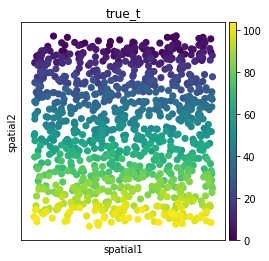

In [249]:
a=simulate_space(a,how='spatial_gradient',spread=50,size_x=size_x,size_y=size_y)
a=simulate_missegmentation(a)
#a=simulate_cytoplasmic_leakage(a,max_cytoplasmic_leakage=0.1)
#a=simulate_boundary_underestimation(a)
# simulate cohabiting_population
if cohabiting==True:
    a2=simulate_cohabiting_population(a,n_cells_ct2=500,size_x=size_x,size_y=size_y/2)
    a2=simulate_missegmentation(a2,max_missegmentation_proportion=0.3,max_distance_misseg=10)
    a2=simulate_cytoplasmic_leakage(a2,max_cytoplasmic_leakage=0.01)
    #a2=simulate_boundary_underestimation(a2)
    a=sc.concat([a,a2])
    a=simulate_missegmentation(a,max_missegmentation_proportion=0.1,max_distance_misseg=2)
sc.pl.spatial(a,color='true_t',spot_size=40)

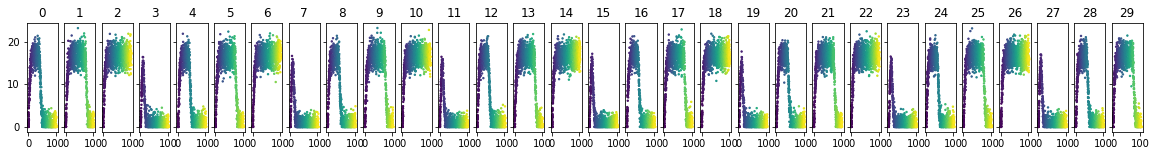

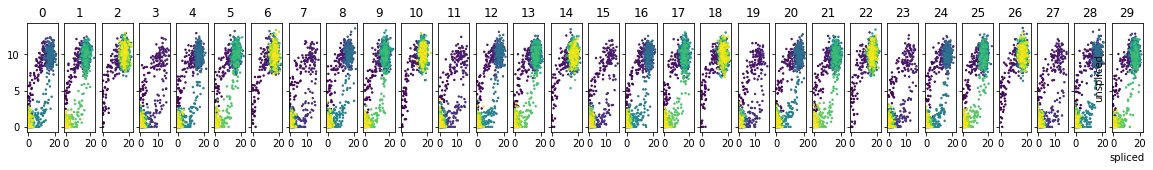

In [250]:
plot_expression_vs_true_time(a)
plot_unspliced_vs_spliced(a)

In [251]:
a
# pca, neighbours, umap, leiden
sc.pp.pca(a)
sc.pp.neighbors(a, n_neighbors = 10, n_pcs=0)
sc.tl.umap(a,min_dist=1)
sc.tl.leiden(a,resolution = 0.1 )

/home/sergio/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


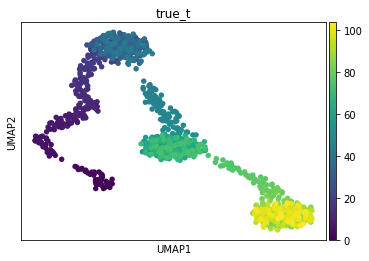

Plotting not possible


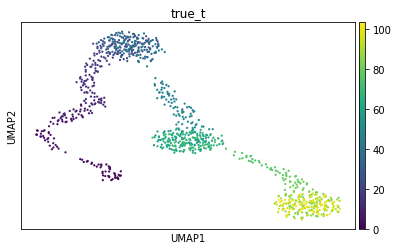

In [252]:
a.obs['missegmented_cell']=a.obs['missegmented_cell'].astype('boolean')*1
a.obs['total_counts']=np.sum(a.X,axis=1)
sc.pl.umap(a,color='true_t')
try:
    sc.pl.umap(a,color=['true_t','boundary_underestimation','total_counts','missegmented_cell','mean_leakage'],s=20,ncols=2)
except:
    print('Plotting not possible')

In [256]:
mode_selected='dynamical'
scv.pp.neighbors(a)
scv.pp.moments(a, n_pcs=None, n_neighbors=None)
scv.tl.velocity(a, mode=mode_selected)
scv.tl.velocity_graph(a)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/32 cores)


  0%|          | 0/1000 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


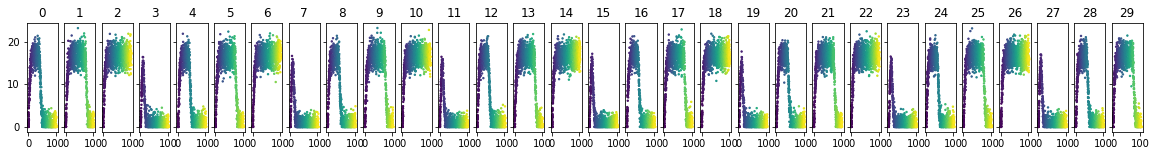

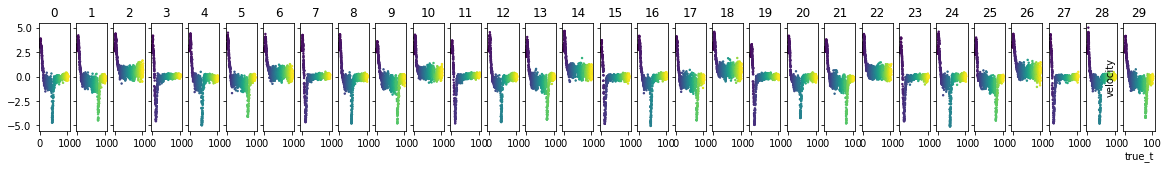

In [255]:
plot_expression_vs_true_time(a)
plot_velocity_vs_true_t(a)

/home/sergio/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


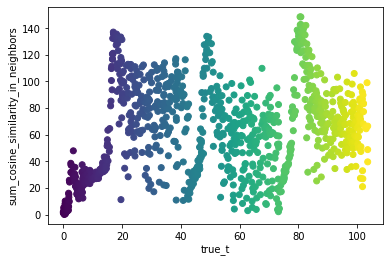

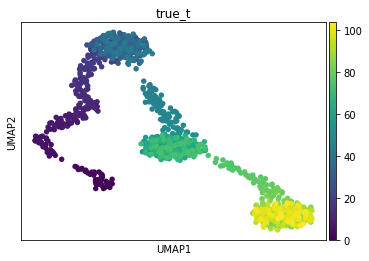

In [257]:
velocity_graph=a.uns['velocity_graph'].todense()
sum_cosine_similarity=pd.DataFrame(velocity_graph.sum(axis=1).transpose()[0,:]).iloc[0,:]
plt.scatter(a.obs['true_t'],sum_cosine_similarity,c=a.obs['true_t'])
plt.ylabel('sum_cosine_similarity_in_neighbors')
plt.xlabel('true_t')
sc.pl.umap(a,color='true_t')

<Axes: >

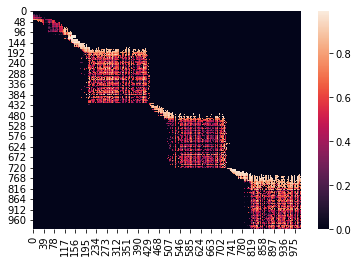

In [258]:
import seaborn as sns
sns.heatmap(velocity_graph)

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


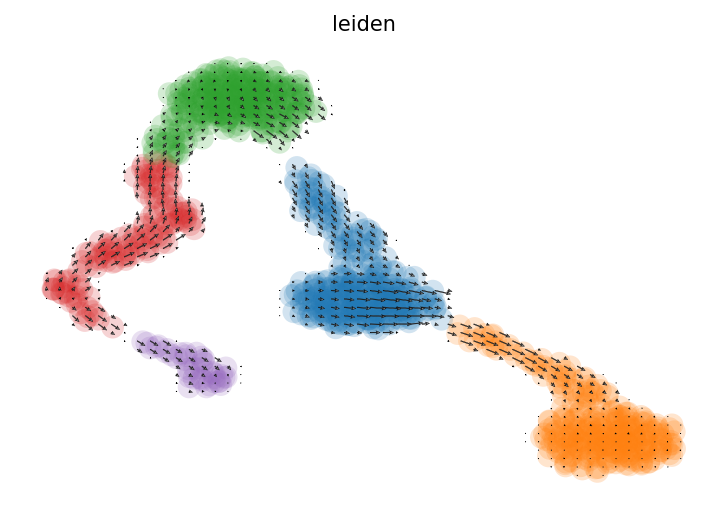

In [259]:
scv.pl.velocity_embedding_grid(a, basis='umap', color='leiden',legend_loc='none',dpi=150)

/home/sergio/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


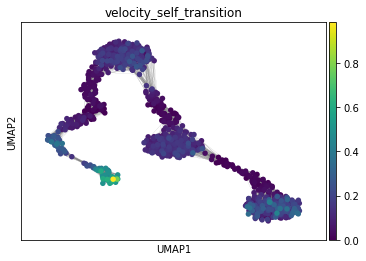

In [260]:
sc.pl.umap(a, color='velocity_self_transition',edges=True)

/home/sergio/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


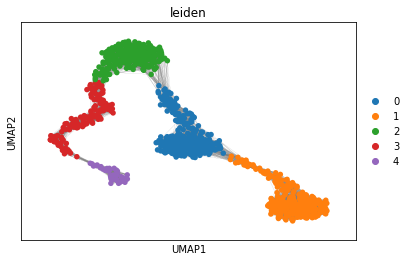

In [261]:
sc.pl.umap(a, color='leiden',edges=True)

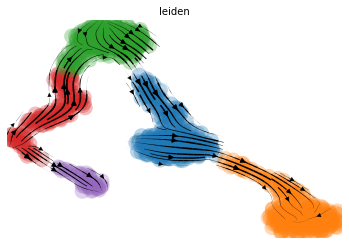

In [262]:
scv.pl.velocity_embedding_stream(a, basis='umap', color='leiden',legend_loc='none')

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


/home/sergio/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


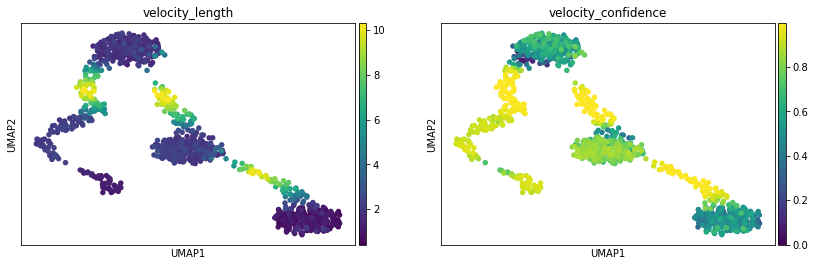

In [263]:
scv.tl.velocity_confidence(a)
keys = 'velocity_length', 'velocity_confidence'
sc.pl.umap(a,color=keys)

In [269]:
scv.tl.recover_dynamics(a)

recovering dynamics (using 1/32 cores)


  0%|          | 0/23 [00:00<?, ?gene/s]

    finished (0:00:04) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


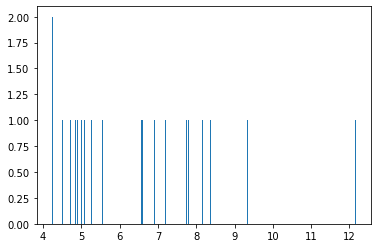

In [270]:
s=plt.hist(a.var['fit_alpha'],bins=400)

# Work with a static population

In [396]:
# set up basic parameters
size_x=1000
size_y=1000
n_genes=30
n_cells=5000
cohabiting=False

In [397]:
a=simulate_static_population(n_transcripts=n_genes,n_cells=1200,size_x=500,size_y=500)

In [398]:
a=simulate_missegmentation(a,max_missegmentation_proportion=0.6,max_distance_misseg=20)
#a=simulate_cytoplasmic_leakage(a,max_cytoplasmic_leakage=0.5)
#a=simulate_boundary_underestimation(a)

/home/sergio/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


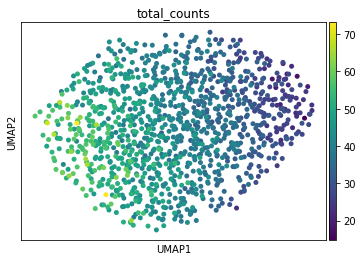

In [399]:
a
# pca, neighbours, umap, leiden
sc.pp.pca(a)
sc.pp.neighbors(a, n_neighbors = 10, n_pcs=0)
sc.tl.umap(a,min_dist=1)
sc.tl.leiden(a,resolution = 0.1 )
a.obs['total_counts']=np.sum(a.X,axis=1)
sc.pl.umap(a,color='total_counts')

In [400]:
mode_selected='dynamical'
scv.pp.neighbors(a)
scv.pp.moments(a, n_pcs=None, n_neighbors=None)
scv.tl.velocity(a, mode=mode_selected)
scv.tl.velocity_graph(a)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
Normalized count data: unspliced.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/32 cores)


  0%|          | 0/1200 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


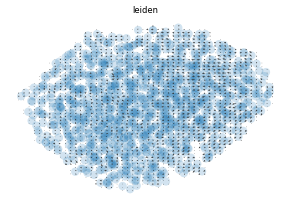

In [401]:
scv.pl.velocity_embedding_grid(a, basis='umap', color='leiden',legend_loc='none',dpi=60)

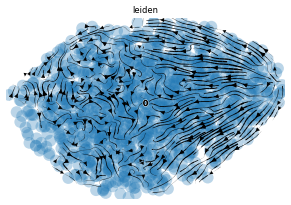

In [402]:
scv.pl.velocity_embedding_stream(a, basis='umap', color='leiden',dpi=60)

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


/home/sergio/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


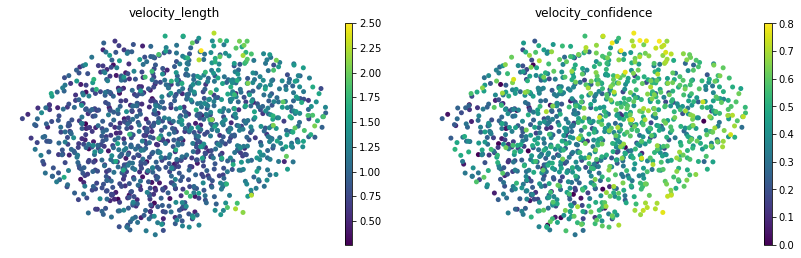

In [403]:
scv.tl.velocity_confidence(a)
keys = 'velocity_length', 'velocity_confidence'
sc.pl.umap(a,color=keys,frameon=False)

# Metrics to evaluate performance of RNA velocity

AnnData object with n_obs × n_vars = 1200 × 30
    obs: 'index', 'true_t', 'x', 'y', 'kind', 'missegmented_cell', 'leiden', 'total_counts', 'n_counts', 'velocity_self_transition', 'velocity_length', 'velocity_confidence', 'velocity_confidence_transition'
    var: 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'velocity_params', 'velocity_graph', 'velocity_graph_neg', 'leiden_colors'
    obsm: 'spatial', 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'variance_velocity'
    obsp: 'distances', 'connectivities'